In [1]:
import importlib

In [2]:
from makemore.prepare_data import generate_character_mapping

with open('data/names.txt', encoding='utf-8') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

character_map = generate_character_mapping(names)
character_map

CharacterMapping(stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}, itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}, vocab_size=27)

In [3]:
from makemore.prepare_data import generate_training_data
import makemore.neural_network
importlib.reload(makemore.neural_network)
from makemore.neural_network import NeuralNetwork, TrainingParams, InitializationType

import random 


random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

X_train,Y_train  = generate_training_data(names[:n1],4)
X_val,Y_val = generate_training_data(names[n1:n2],4)
X_test,Y_test = generate_training_data(names[n2:],4)

nn_bad_initialization = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True, initialization_type=InitializationType.no_fixes)
nn_bad_initialization.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 24.230430603027344
Loss after 334 epochs: 3.159198760986328
Loss after 667 epochs: 2.8260340690612793
Loss after 1000 epochs: 2.7092947959899902
NN_4_150_3 loss:after 1000 epochs: 2.73844575881958


# Playing with the initial loss

[Chapter in Youtube](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=259s)

What to do we expect the loss to be at initialization? 

- Our loss function right now is the negative log likelihood average function.  If the probability is close to 0, the loss is exponentially high. 

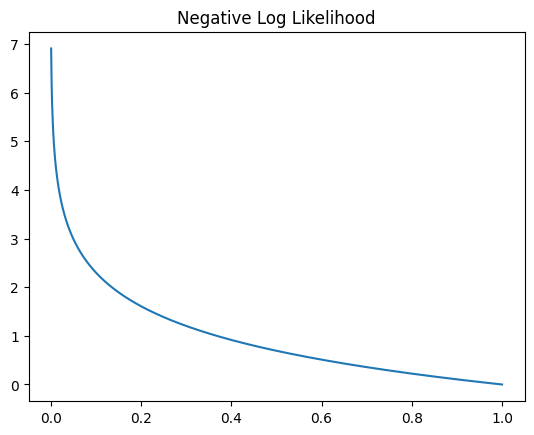

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# visualize negativ log likelyhood with matplotlib

sample_xs = np.linspace(0.001, 1, 1000)
sample_ys = [-np.log(x) for x in sample_xs]
plt.plot(sample_xs,sample_ys)
plt.title("Negative Log Likelihood")
plt.show()


- Considering that we have 27 characters to be predicted, the average loss is a bit too high. 
- With uniform prediction we would have **(4 %/0.04)** chance of making the right guess. 
- From negative log likelihood perspectice, this should be average value around 3 visually looking

An example of this

In [5]:
-np.log(1/27)

3.295836866004329

Reallity hits us

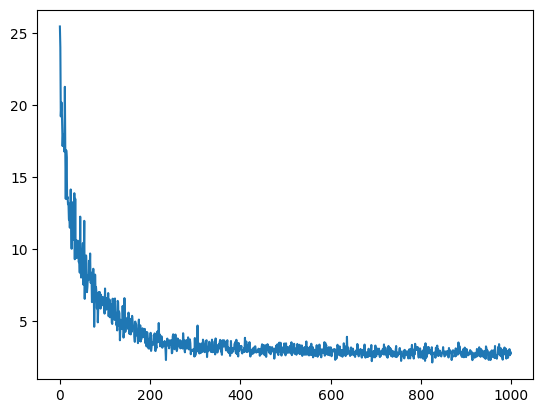

In [6]:
import matplotlib.pyplot as plt

plt.plot(nn_bad_initialization.losses)

So why is it around 25-27 in the beginning of training in this case?

- We are randomly initializing the params. The logits generated are then run through sigmoid function which in itself actually powers the differences between predictions. If we are wrong, we are wrong powerfully and that is powered by out cost function: negative log likelihood function (visualized above)

So, how would you solve this?

- Perhaps initialize all parameters uniformly. So every possibility is equal. 


In [7]:
importlib.reload(makemore.neural_network)
from makemore.neural_network import NeuralNetwork, TrainingParams

nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True,initialization_type=InitializationType.avoid_being_confidently_wrong)
nn.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))
for i in range(1):
    print(nn.generate_name())

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 3.311779022216797
Loss after 334 epochs: 2.556411027908325
Loss after 667 epochs: 2.5103542804718018
Loss after 1000 epochs: 2.4619197845458984
NN_4_150_3 loss:after 1000 epochs: 2.530968427658081
[5, 12, 5, 14, 0]


Muchos bette

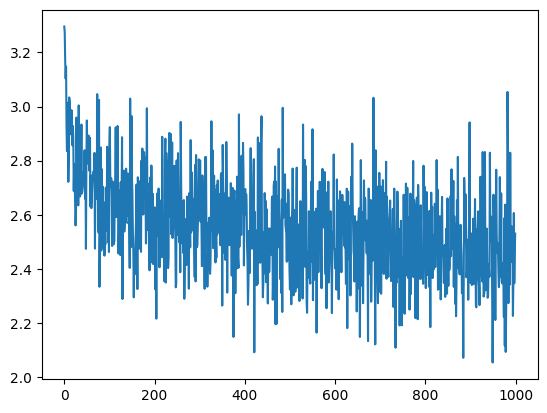

In [8]:
plt.plot(nn.losses)

# Tanh function result

First, lets look at tanh function

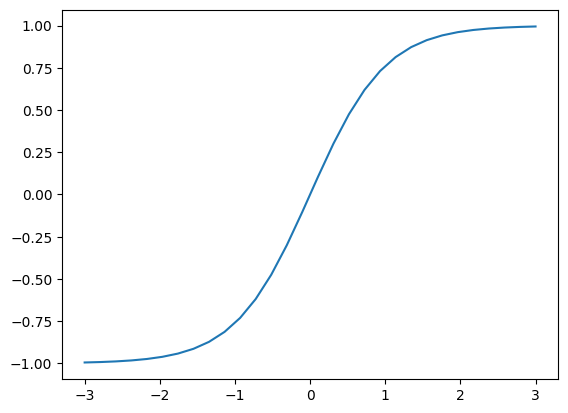

In [16]:
import torch
tan_graph = torch.linspace(-3,3,30).tanh()
plt.plot(torch.linspace(-3,3,30),tan_graph)

Tanh function results

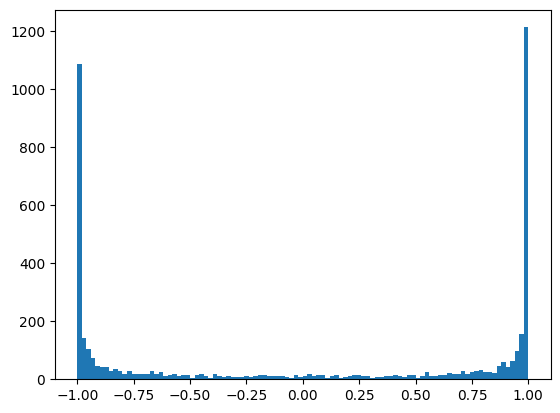

In [17]:

minibatch = torch.randint(0, len(X_train), (30,))
h = (nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1).tanh()
histogram_plot = plt.hist(h.view(-1).tolist(), bins=100)


Before tanh function 

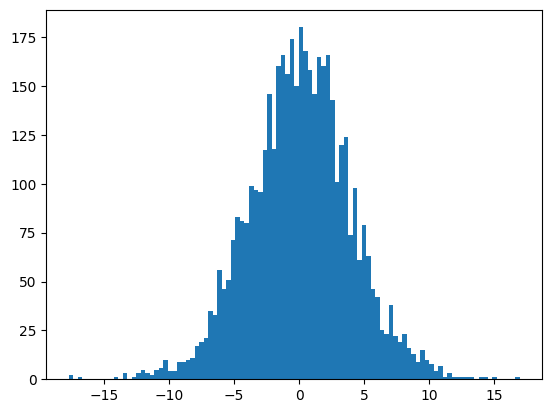

In [18]:
minibatch = torch.randint(0, len(X_train), (30,))
pre_h = nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1
histogram_plot = plt.hist(pre_h.view(-1).tolist(), bins=100) 

According to Andrej Karpahty this is not good, why?

- If we look at tanh function and its gradient from the previous micrograd lecture, when the outcome of tanh function is 1 or -1 then the gradient will become 0 and will make all the upstream parameters gradients also 0. If it happens to all datas, then we have something called the dead gradient problem in our hands.


~~~python
def tanh(self): # https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - out.data**2) * out.grad
        self._gradient_updates+=1

    out._backward = _backward     
    return out
~~~

Showing locations where the tanh output equals 1 which means the gradient would equal to 0.  The white part in this graph is where h is greater than 0.99

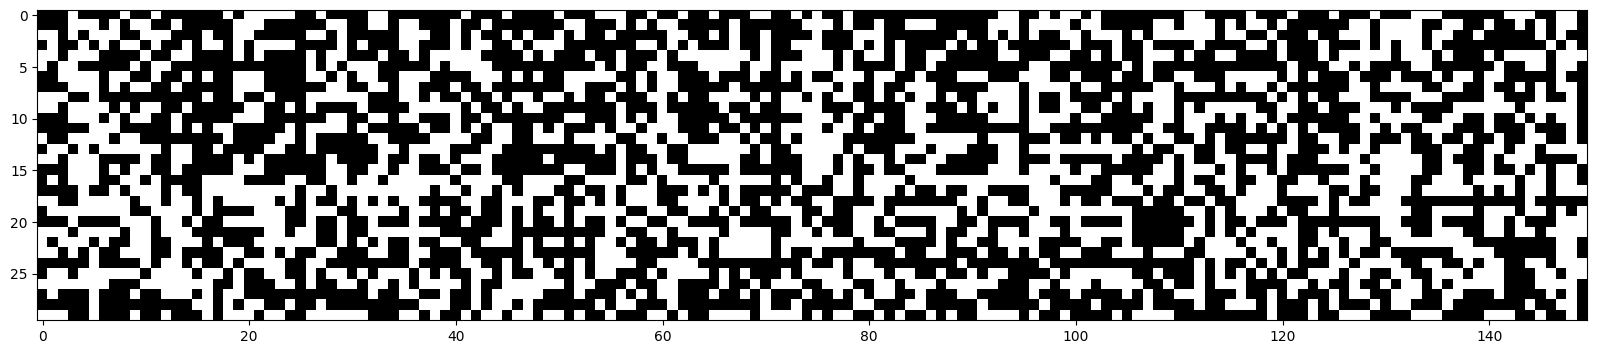

In [24]:
plt.figure(figsize=(20,10))
p=plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Let's now look into the possibility of making the input to tanh squashed down

In [ ]:
nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3,print_flag=True,initialization_type=InitializationType.squash_h)

